>> # Modelo de Predição para Identificar Devedores Propensos a Pagar um Título
- Modelagem preditiva para devedor mais propenso a pagar
- Este Jupyter contém as etapas de ETL e Modelagem

# Importando pacotes e bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os , gc, time, urllib, pyodbc, warnings
warnings.filterwarnings("ignore")
from datetime import date, timedelta
import sqlalchemy as sql
from sqlalchemy import create_engine
import ast
import glob



# ETL


### Coleta dos dados de remessas

In [3]:
# Coletar Dados de remessa

path1 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxx/01/'
path2 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxx/02/'
path3 = r'v/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxx/03/'
path4 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/01/'
path5 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/02/'
path6 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/03/'

In [4]:
def coleta_mailing(path): 
    
    all_files = glob.glob(path + "/*.csv")
    colunas = ['Instalacao','CNPJ_CPF','RoteirodeLeitura', 'CEPInstalacao', 'CodgDaClasse',  'Valor', 'SitInstalacaoLigado_Desligado', 
                 'UF',  'VencimDaFatura', 'Segmento']
                
    li = []
    for filename in all_files:
        arq = pd.read_csv(filename, index_col=None, header=0, sep=",",  encoding='latin1', usecols=colunas)
        li.append(arq)

    #Coleta Mes 1
    df = pd.concat(li, axis=0, ignore_index=True)
    del li
    del arq
    df.drop_duplicates(inplace=True)
    return df

In [5]:
df1 = coleta_mailing(path1)
df2 = coleta_mailing(path2)
#df3 = coleta_mailing(path3)
df4 = coleta_mailing(path4)
df5 = coleta_mailing(path5)
df6 = coleta_mailing(path6)


In [6]:
df1.shape, df2.shape, df4.shape, df5.shape, df6.shape

((56843, 10), (28661, 10), (65111, 10), (21392, 10), (9443, 10))

In [7]:
df = pd.concat([df1, df2, df4, df5, df6], axis=0)
df.shape

(181450, 10)

### Coleta de dados para a variavel target

In [8]:
# Coletar Dados de remessa

path10 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/Exclusões/01/'
path20 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxx/Exclusões/02/'
path30 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxx/Exclusões/03/'
path40 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxx/Exclusões/01/'
path50 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/Exclusões/02/'
path60 = r'v:/Drives compartilhados/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx/Exclusões/03/'

In [9]:
def coleta_exclusao(path): 
    
    all_files = glob.glob(path + "/*.csv")
    colunas = ['inst','FlagRecebivel']
                
    li = []
    for filename in all_files:
        arq = pd.read_csv(filename, index_col=None, header=0, sep=",",  encoding='latin1', usecols=colunas)
        li.append(arq)

    #Coleta Mes 1
    pagos = pd.concat(li, axis=0, ignore_index=True)
    del li
    del arq
    pagos.drop_duplicates(inplace=True)
    return pagos

In [10]:
pago1 = coleta_exclusao(path10)
pago2 = coleta_exclusao(path20)
pago3 = coleta_exclusao(path30)
pago4 = coleta_exclusao(path40)
pago5 = coleta_exclusao(path50)
pago6 = coleta_exclusao(path60)

pago = pd.concat([pago1, pago2, pago3, pago4, pago5, pago6], axis=0)
pago.drop_duplicates(inplace=True)
pago.shape

(143032, 2)

In [11]:
data = pd.merge(df, pago, how="left", left_on='Instalacao', right_on='inst')
data.shape

(186433, 12)

In [12]:
df = data

## Engenharia de Atributos

In [13]:
df['VencimDaFatura'] = pd.to_datetime(df['VencimDaFatura'], format='%d/%m/%Y')
df['Segmento'] = df['Segmento'].astype(str)
df['Segmento'] = df.Segmento.apply(lambda x: x.replace(".",""))
df['FlagRecebivel'] = df['FlagRecebivel'].fillna(0)
df['FlagRecebivel'] = df['FlagRecebivel'].replace(['X'], [1])
df['FlagRecebivel'] = df['FlagRecebivel'].replace([' '], [0])


In [14]:
df.FlagRecebivel.value_counts()

1    125735
0     60698
Name: FlagRecebivel, dtype: int64

In [15]:
df['TARGET'] = df['FlagRecebivel']

In [16]:
df.TARGET.value_counts()

1    125735
0     60698
Name: TARGET, dtype: int64

## Analise Exploratória

In [17]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile


Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


# Pre Processamento dos dados

## Balanceamento de Variáveis

In [18]:
df.TARGET.value_counts()

1    125735
0     60698
Name: TARGET, dtype: int64

Class 0: 60698
Class 1: 125735
Proportion: 0.48 : 1


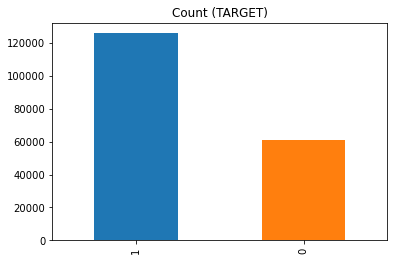

In [19]:
target_count = df['TARGET'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

Random under-sampling:
0    60698
1    60698
Name: TARGET, dtype: int64


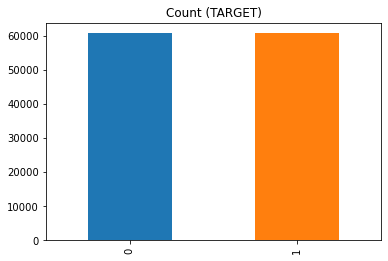

In [20]:
# CONTAR CLASSES
count_class_1, count_class_0 = df['TARGET'].value_counts()
# Divide by class
df_class_0 = df[df['TARGET'] == 0]
df_class_1 = df[df['TARGET'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
df = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(df['TARGET'].value_counts())
df['TARGET'].value_counts().plot(kind='bar', title='Count (TARGET)',color = ['#1F77B4', '#FF7F0E']);

In [21]:
df.TARGET.value_counts()

0    60698
1    60698
Name: TARGET, dtype: int64

In [22]:
df.columns

Index(['Instalacao', 'RoteirodeLeitura', 'CEPInstalacao', 'CodgDaClasse',
       'Valor', 'VencimDaFatura', 'CNPJ_CPF', 'UF',
       'SitInstalacaoLigado_Desligado', 'Segmento', 'inst', 'FlagRecebivel',
       'TARGET'],
      dtype='object')

In [23]:
df.dtypes

Instalacao                               object
RoteirodeLeitura                         object
CEPInstalacao                            object
CodgDaClasse                              int64
Valor                                   float64
VencimDaFatura                   datetime64[ns]
CNPJ_CPF                                  int64
UF                                       object
SitInstalacaoLigado_Desligado            object
Segmento                                 object
inst                                     object
FlagRecebivel                             int64
TARGET                                    int64
dtype: object

In [24]:
features = df[[ 'RoteirodeLeitura', 'CEPInstalacao', 'Valor', 'UF' ,'Segmento']]
target = df[['TARGET']]

## Padronização ou Normalização das variáveis

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
features['RoteirodeLeitura']= le.fit_transform(features["RoteirodeLeitura"])
features['CEPInstalacao']= le.fit_transform(features["CEPInstalacao"])
features['UF']= le.fit_transform(features["UF"])
#features['SitInstalacaoLigado_Desligado']= le.fit_transform(features["SitInstalacaoLigado_Desligado"])
features['Segmento']= le.fit_transform(features["Segmento"])


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features['Valor'] = scaler.fit_transform(features[['Valor']])



# Modelagem preditiva

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [27]:
# Separando as features e target
X = features
Y = target

# Divide os dados em treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

# Criando o modelo
#Model = RandomForestClassifier(n_estimators=100)
#Model = GradientBoostingClassifier(n_estimators=150,  learning_rate=0.1)
#Model = MLPClassifier(hidden_layer_sizes=(50,50,50), alpha=0.01 )
Model = XGBClassifier(nthread = 48, objective = 'binary:logistic',  max_depth = 6, n_estimators=150) 

# Definindo os valores para o número de folds
num_folds = 5
seed = 7
    
# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)    

# Treinando o modelo
Model.fit(X_train, Y_train)

# Previsão do modelo
Predict = Model.predict(X_test)

# Acurácia final e ROC
resultadoAC = cross_val_score(Model, X, Y, cv = kfold, scoring = 'accuracy')
#resultadoROC = cross_val_score(Model, X, Y, cv = kfold, scoring = 'roc_auc')

print("A Acurácia foi de: %.3f%%" % (resultadoAC.mean() * 100.0))
#print("ROC foi de: %.3f" % (resultadoROC.mean() * 100))

report = classification_report(Y_test, Predict)

# Imprimindo o relatório
print(report)

[15:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:55:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.63      0.60      0.61     20012
           1       0.62      0.64      0.63     20049

    accuracy                           0.62     40061
   macro avg       0.62      0.62      0.62     40061
weighted avg       0.62      0.62      0.62     40061



### Análise de Features e Acurácia

In [30]:
# Seleção dos melhores atributos como resultado para a modelagem CPC
gc.collect()
Model.feature_importances_
feature_importances = pd.DataFrame(Model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
RoteirodeLeitura,0.275690
Valor,0.270440
Segmento,0.240138
CEPInstalacao,0.213733
UF,0.000000


In [32]:
# Salvando o modelo Propensao a pagar
import pickle

arquivo_cpf = 'modelo_v1.sav'
pickle.dump(Model, open(arquivo_cpf, 'wb'))
print("Modelo salvo!")

# Salvar as features do modelo
with open('NameFeature_v1','wb') as arquivo_cpf:
   pickle.dump(features.columns, arquivo_cpf)

print('Nomes Salvo')

Modelo salvo!
Nomes Salvo
